Livrable 1

Ajout des dépendances

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pathlib
import time

Chargement des données

In [2]:
#Paramètres

batch_size = 32
img_height = 180
img_width = 180
num_classes = 6
input_shape = (32, 180, 180, 3)

In [3]:
current_dir = pathlib.Path().resolve()
DATASET_SIZE = len(list(current_dir.glob('data/*/*')))

full_dataset = tf.data.Dataset.list_files(str(current_dir / 'data/*/*'), shuffle=False)
full_dataset = full_dataset.shuffle(DATASET_SIZE, reshuffle_each_iteration=False)

# list_ds = tf.data.Dataset.list_files(str(data_dir/'data/*/*'), shuffle=False)

# list_ds = list_ds.shuffle(DATASET_SIZE, reshuffle_each_iteration=False)
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

print(DATASET_SIZE)
# val_size = int(DATASET_SIZE * 0.2)
# train_ds = list_ds.skip(val_size)
# val_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_dataset).numpy())
print(tf.data.experimental.cardinality(test_dataset).numpy())
print(tf.data.experimental.cardinality(val_dataset).numpy())

41555
29088
6233
6234


In [4]:
class_names = np.array(sorted([item.name for item in current_dir.glob('data/*')]))
print(class_names)

['Dataset' 'Painting' 'Photo' 'Schematics' 'Sketch' 'Text']


In [5]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [12]:
from tensorflow.python.data import AUTOTUNE

print(train_dataset)
print(test_dataset)
print(val_dataset)

train_ds = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

<TakeDataset shapes: (), types: tf.string>
<TakeDataset shapes: (), types: tf.string>
<SkipDataset shapes: (), types: tf.string>


In [13]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


In [14]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=10000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

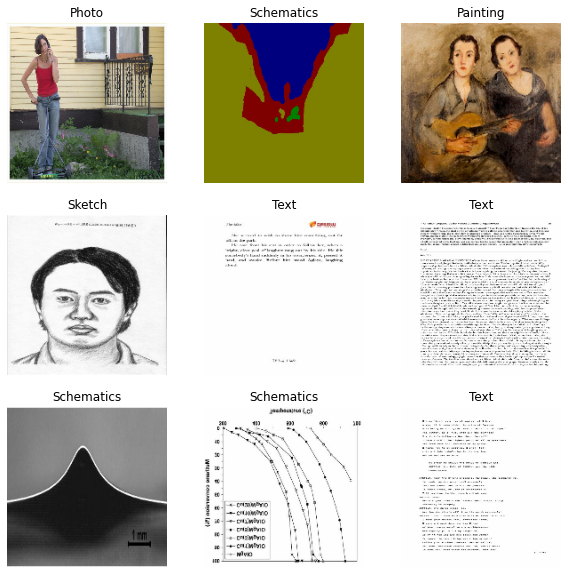

In [15]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Standardisation des données

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [18]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (32, 178, 178, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 89, 89, 32)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (32, 89, 89, 32)          0         
                                                                 
 conv2d_4 (Conv2D)           (32, 87, 87, 32)          9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 43, 43, 32)         0         
 2D)                                                  

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
#Utilisation des rappels de point de contrôle

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=batch_size)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

latest = tf.train.latest_checkpoint(checkpoint_dir)
# Load the previously saved weights
model.load_weights(latest)

# Train the model with the new callback
# model.fit(train_images,
#           train_labels,
#           epochs=50,
#           batch_size=batch_size,
#           validation_data=(test_images, test_labels),
#           verbose=0)

#Entraînement du modèle
model.fit(
  train_ds,
  callbacks=[cp_callback],
  validation_data=val_ds,
  epochs=3,
  shuffle=True
)

Epoch 1/3
 31/909 [>.............................] - ETA: 7:44 - loss: 1.4241 - accuracy: 0.3679
Epoch 00001: saving model to training\cp-0001.ckpt
 63/909 [=>............................] - ETA: 8:07 - loss: 1.2458 - accuracy: 0.4549
Epoch 00001: saving model to training\cp-0001.ckpt
 95/909 [==>...........................] - ETA: 8:06 - loss: 1.1162 - accuracy: 0.5161
Epoch 00001: saving model to training\cp-0001.ckpt
127/909 [===>..........................] - ETA: 7:51 - loss: 1.0228 - accuracy: 0.5593
Epoch 00001: saving model to training\cp-0001.ckpt
159/909 [====>.........................] - ETA: 7:27 - loss: 0.9429 - accuracy: 0.5955
Epoch 00001: saving model to training\cp-0001.ckpt
191/909 [=====>........................] - ETA: 7:07 - loss: 0.8919 - accuracy: 0.6158
Epoch 00001: saving model to training\cp-0001.ckpt
223/909 [======>.......................] - ETA: 6:45 - loss: 0.8574 - accuracy: 0.6321
Epoch 00001: saving model to training\cp-0001.ckpt
255/909 [=======>.......

KeyboardInterrupt: 

Validation des données

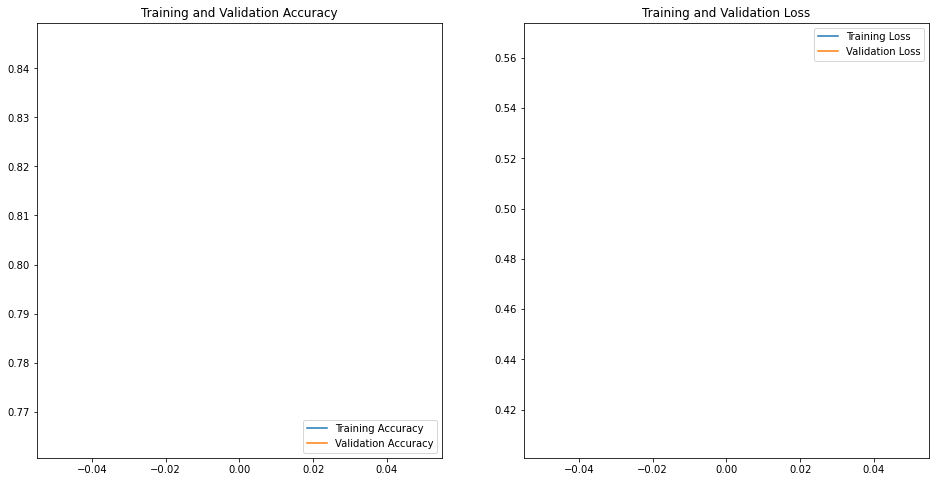

In [24]:

history = model.history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, acc = model.evaluate(test, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))